<a href="https://colab.research.google.com/github/daspartho/learn-pytorch/blob/main/paper_replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import torchvision
import torch

from torch import nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from modular import data_setup, engine
except:
    print("[INFO] Couldn't find modular scripts... downloading from GitHub.")
    !git clone https://github.com/daspartho/learn-pytorch
    !mv learn-pytorch/modular .
    !rm -rf learn-pytorch
    from modular import data_setup, engine

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find modular scripts... downloading from GitHub.
Cloning into 'learn-pytorch'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 130 (delta 56), reused 117 (delta 54), pack-reused 10
Receiving objects: 100% (130/130), 8.28 MiB | 12.57 MiB/s, done.
Resolving deltas: 100% (56/56), done.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3107, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 3107 (delta 14), reused 33 (delta 11), pack-reused 3067
Receiving objects: 100% (3107/3107), 640.08 MiB | 28.34 MiB/s, done.
Resolving deltas: 100% (1766/1766), done.
Checking out files: 100% (218/218), done.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [4]:
train_dir = image_path/ "train"
test_dir = image_path/ "test"

In [5]:
IMG_SIZE = 224

transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

In [6]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir,
    test_dir,
    transforms,
    BATCH_SIZE,
)

In [7]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

(-0.5, 223.5, 223.5, -0.5)

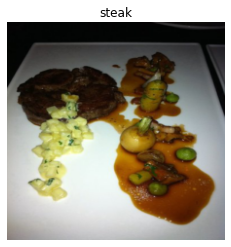

In [8]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [9]:
class PatchEmbedding(nn.Module):

    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        self.patcher = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size,
            padding=0,
        )

        self.flatten = nn.Flatten(
            start_dim=2, 
            end_dim=3,
            )

    def forward(self, x):
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        return x_flattened.permute(0,2,1)

In [10]:
print(f"Image shape: {image.shape}")

x = image.unsqueeze(dim=0)
print(f"Image with batch dim shape: {x.shape}")

patchify = PatchEmbedding()
patch_embedding = patchify(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

class_token = nn.Parameter(
    torch.randn(1, 1, 768), 
    requires_grad=True,
    )
print(f"Class token shape: {class_token.shape}")

patch_embedding_class_token = torch.cat(
    (class_token, patch_embedding), 
    dim=1,
    )
print(f"Patch embedding class token shape: {patch_embedding_class_token.shape}")

position_embedding = nn.Parameter(
    torch.randn(1, 197, 768),
    requires_grad=True,
)
print(f"Position embedding shape: {position_embedding.shape}")

patch_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch position embedding shape: {patch_position_embedding.shape}")

Image shape: torch.Size([3, 224, 224])
Image with batch dim shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token shape: torch.Size([1, 1, 768])
Patch embedding class token shape: torch.Size([1, 197, 768])
Position embedding shape: torch.Size([1, 197, 768])
Patch position embedding shape: torch.Size([1, 197, 768])
